In [12]:
import torch
from tqdm.notebook import tqdm
import numpy as np

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import wandb
import random


df1 = pd.read_csv('master_rf.csv')
df2 = pd.read_csv('master_rf_holdout.csv')
print(df1.head(10))
print(df2.head(10))

   label                                               body
0      0  Something broke inside  \nIt's never gonna be ...
1      0  I can't get anything done because i have no mo...
2      0  I’m about to go to college only to make my par...
3      0  Maybe genetics, maybe childhood trauma, maybe ...
4      0  i drank yesterday so i had a headache and cut ...
5      0  I’ve been doing a little reading about functio...
6      0  I'm lost. I can't even get out of the house. I...
7      0  Basically after being depressed for years I to...
8      0  Everyday it's getting harder to get out of bed...
9      0  I stopped taking zoloft a few months ago (afte...
   label                                               body
0      0  i know i’m only 16 so this, in other people’s ...
1      0  Every moment that I sit with myself in pain an...
2      0  i wouldn’t ever downplay anyone’s struggles, e...
3      0  I’m struggling. Bad. I can’t get out of bed no...
4      0  \n\nDon’t even know what I’m l

In [2]:
wandb.login()

%env WANDB_PROJECT=Mental_Health


wandb: Currently logged in as: banalyst (use `wandb login --relogin` to force relogin)


env: WANDB_PROJECT=Mental_Health


In [3]:
X_train, X_val, y_train, y_val = train_test_split(df1.body.values, 
                                                  df1.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df1.label.values)


df1.shape

(24854, 2)

In [4]:
y_train

array([2, 2, 4, ..., 4, 0, 1], dtype=int64)

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    X_train, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding=True, 
    max_length=512,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    X_val, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding=True, 
    max_length=512,
    truncation=True,
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    df2['body'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding=True,
    max_length=512,
    truncation=True,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_val)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(df2['label'].values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)



In [6]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 4

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

dataloader_test = DataLoader(dataset_test, 
                             sampler=SequentialSampler(dataset_test), 
                             batch_size=batch_size)

In [7]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=6,
                                                      output_attentions=False,
                                                      output_hidden_states=False)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [8]:
from transformers import AdamW, get_linear_schedule_with_warmup


optimizer = AdamW(model.parameters(),
                  lr=5e-5, 
                  eps=1e-8)

epochs = 5

total_steps = len(dataloader_train) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)


In [9]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')



def accuracy_per_class(preds, labels):
    
    label_dict = {
        'depression': 0,
        'ptsd': 1,
        'cptsd': 2,
        'bpd': 3,
        'bipolar': 4,
        'dissociation': 5
    }
    
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}' )
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [10]:
import random
import numpy as np


seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)





def evaluate(dataloader_val):

    # Pass your defaults to wandb.init
    wandb.init()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval().to(device)
    
    loss_val_total = 0
    predictions, true_vals = [], []

    
    for batch in dataloader_val:
        logits = 0
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }
        
        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        
    loss_val_avg = loss_val_total/len(dataloader_val) 
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    wandb.log({'loss_val': loss_val_avg})

    wandb.log({"roc_plot_1": wandb.plot.roc_curve(true_vals,
                             predictions, 
                             labels=['depression',
                                     'ptsd',
                                     'cptsd',
                                     'bpd',
                                     'bipolar',
                                     'dissociation'])})
    return loss_val_avg, predictions, true_vals
    
    



def train():

    # Pass your defaults to wandb.init
    wandb.init()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for epoch in tqdm(range(1, epochs+1)):
    
        model.train().to(device)
        
        wandb.log({'epoch': epoch})
        loss_train_total = 0

        progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
        for batch in progress_bar:

            model.zero_grad()
        
            batch = tuple(b.to(device) for b in batch)
        
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'labels':         batch[2],
                     }       

            outputs = model(**inputs)
          
            loss = outputs[0]
            loss_train_total += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()
        
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
            wandb.log({"loss_train": loss.item()})
        
        torch.save(model.state_dict(), f'c:/users/chung/desktop/springboard_stuff/bert-master/model/finetune/model_{epoch}.model')
        
        tqdm.write(f'\nEpoch {epoch}')
    
        loss_train_avg = loss_train_total/len(dataloader_train)   
        wandb.log({'loss_train': loss_train_avg})
        tqdm.write(f'Training loss: {loss_train_avg}')
        
    
        val_loss, predictions, true_vals = evaluate(dataloader_validation)
        val_f1 = f1_score_func(predictions, true_vals)
        accuracy_per_class(predictions, true_vals)
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (Weighted): {val_f1}')
        tqdm.write(f'train loss avg: {loss_train_avg}')
        wandb.log({"roc_plot_1" : wandb.plot.roc_curve(true_vals,
                        predictions, labels=['depression','ptsd','cptsd','bpd','bipolar','dissociation'])})



        
        

        


In [11]:
train()

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/5282 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.069867078343245


epoch,1
_runtime,2581
_timestamp,1619566654
_step,5283
loss_train,1.06987


epoch,▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss_train,▆▆▃▂▅▅▃▂▃▃▄▄▂▆▁█▄▄▃▃▁▄▄▄▁▃▅▇▂▃█▄▁▁▂▅▄▂▁▃


Class: depression
Accuracy: 551/772

Class: ptsd
Accuracy: 424/552

Class: cptsd
Accuracy: 207/583

Class: bpd
Accuracy: 632/787

Class: bipolar
Accuracy: 323/537

Class: dissociation
Accuracy: 369/498

Validation loss: 0.9127481723841108
F1 Score (Weighted): 0.6656196312881071
train loss avg: 1.069867078343245


Epoch 2:   0%|          | 0/5282 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.7717614282445897


loss_val,0.91275
_runtime,2731
_timestamp,1619569388
_step,5286
epoch,2
loss_train,0.77176


loss_val,▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,▁
loss_train,▃▁▃▁▁▂▃▃▁▁▁▂▁▁▃▁▃▁▁▃▁▁▂▄▁▁▁▂▄▁▂▄▅▃▂▅▂█▁▁


Class: depression
Accuracy: 622/772

Class: ptsd
Accuracy: 426/552

Class: cptsd
Accuracy: 343/583

Class: bpd
Accuracy: 594/787

Class: bipolar
Accuracy: 372/537

Class: dissociation
Accuracy: 422/498

Validation loss: 0.8918429969271918
F1 Score (Weighted): 0.7440252328098912
train loss avg: 0.7717614282445897


Epoch 3:   0%|          | 0/5282 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.5432230089761144


loss_val,0.89184
_runtime,2742
_timestamp,1619572133
_step,5286
epoch,3
loss_train,0.54322


loss_val,▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,▁
loss_train,▁▂▄▁▄▅▁▁▁▃▁▁▁▁▁▁▁▄▁▁▁▁▁▃█▁▆▁▁▅▄▂▁▁▁▃▁▁▁▁


Class: depression
Accuracy: 542/772

Class: ptsd
Accuracy: 419/552

Class: cptsd
Accuracy: 448/583

Class: bpd
Accuracy: 585/787

Class: bipolar
Accuracy: 394/537

Class: dissociation
Accuracy: 441/498

Validation loss: 1.2220370888965562
F1 Score (Weighted): 0.7585510405369487
train loss avg: 0.5432230089761144


Epoch 4:   0%|          | 0/5282 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.33368173485360153


loss_val,1.22204
_runtime,2590
_timestamp,1619574726
_step,5286
epoch,4
loss_train,0.33368


loss_val,▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,▁
loss_train,▁▁▁▁▁▁▁▁▁▇█▁▁▁▁▆▁▁▁▁▁█▁▁▁▁▁▅▁▁▁▆▆▁▁▁▁▁▂▂


Class: depression
Accuracy: 606/772

Class: ptsd
Accuracy: 413/552

Class: cptsd
Accuracy: 463/583

Class: bpd
Accuracy: 612/787

Class: bipolar
Accuracy: 398/537

Class: dissociation
Accuracy: 431/498

Validation loss: 1.2459568680291007
F1 Score (Weighted): 0.7837794432840378
train loss avg: 0.33368173485360153


Epoch 5:   0%|          | 0/5282 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.16521444534181148


loss_val,1.24596
_runtime,2628
_timestamp,1619577357
_step,5286
epoch,5
loss_train,0.16521


loss_val,▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,▁
loss_train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁█▁▁


Class: depression
Accuracy: 597/772

Class: ptsd
Accuracy: 434/552

Class: cptsd
Accuracy: 439/583

Class: bpd
Accuracy: 625/787

Class: bipolar
Accuracy: 408/537

Class: dissociation
Accuracy: 428/498

Validation loss: 1.4220863053333592
F1 Score (Weighted): 0.7860473521785355
train loss avg: 0.16521444534181148


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loss_val,0.44509
_runtime,24
_timestamp,1619749034
_step,1


loss_val,▁
_runtime,▁▁
_timestamp,▁▁
_step,▁█


wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Class: depression
Accuracy: 95/100

Class: ptsd
Accuracy: 92/100

Class: cptsd
Accuracy: 93/100

Class: bpd
Accuracy: 91/100

Class: bipolar
Accuracy: 93/100

Class: dissociation
Accuracy: 94/100

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       100
           1       0.94      0.92      0.93       100
           2       0.92      0.93      0.93       100
           3       0.90      0.91      0.91       100
           4       0.92      0.93      0.93       100
           5       0.96      0.94      0.95       100

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600

Matthews Correlation Coefficient: 0.9160183205496184
hamming loss: 0.07


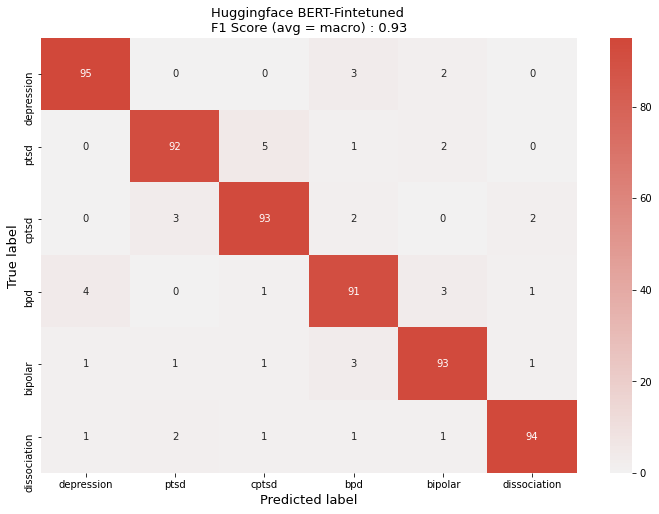

In [13]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=6,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.load_state_dict(torch.load('c:/users/chung/desktop/springboard_stuff/bert-master/model/finetune/model_5.model', 
                                 map_location=torch.device('cpu')))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

_, predictions, true_vals = evaluate(dataloader_test)

f1_score_func(predictions, true_vals)
accuracy_per_class(predictions, true_vals)


y_pred = []
for row in predictions:
    row = np.argmax(row)
    y_pred.append(row)
print(classification_report(y_true = true_vals, y_pred = y_pred))
print("Matthews Correlation Coefficient: {}".format(matthews_corrcoef(y_true=true_vals, y_pred=y_pred)))
print("hamming loss: {}".format(hamming_loss(y_true = true_vals, y_pred = y_pred)))
cm = confusion_matrix(y_true = true_vals, 
                      y_pred = y_pred
                     )
cm_df = pd.DataFrame(cm,
                     index = ['depression','ptsd','cptsd', 'bpd', 'bipolar', 'dissociation'], 
                     columns = ['depression','ptsd','cptsd', 'bpd', 'bipolar', 'dissociation']
                    )

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('Huggingface BERT-Fintetuned \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(true_vals, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()

